# Waymo: TA distribution 

- Distribution plot
    - Total
    - Merge
    - Cross 

In [1]:
import pickle
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scienceplots
from tqdm import tqdm
from shapely import LineString, Point
from seaborn import displot, histplot, relplot
plt.style.use(['nature'])

from waymo_devkit.conflict import Conflict

In [2]:
with open('./pkl/conflict_pet15s.pkl', 'rb') as file:
    conflict_list_from_pickle = pickle.load(file)
print(f"#Conflicts: {len(conflict_list_from_pickle)}")

conflict_list = list()
for c in conflict_list_from_pickle:
    conflict_list.append(
        Conflict(
            leader_id=c['leader_id'],
            leader_index=c['leader_index'],
            leader_states=c['leader_states'],
            leader_time_at_conflict=c['leader_time_at_conflict'],
            follower_id=c['follower_id'],
            follower_index=c['follower_index'],
            follower_states=c['follower_states'],
            follower_time_at_conflict=c['follower_time_at_conflict'],
            PET=c['PET'],
            conflict_type=c['conflict_type'],
            leader_is_av=c['leader_is_av'],
            follower_is_av=c['follower_is_av'],
            center=c['center'],
            radius=c['radius'],
    ))

#Conflicts: 889


In [3]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
- TA
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    "TA"
]

# generate each rows in the dataframe
conflict_rows_in_df = list()
for conflict in conflict_list:
    timeAdvantage_list = conflict.time_advantages
    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    PET = conflict.PET
    for TA in timeAdvantage_list:
        conflict_rows_in_df.append([
                conflict_type,
                leader_type+"-"+follower_type,
                PET,
                TA,
            ])

conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info(), conflict_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53194 entries, 0 to 53822
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  53194 non-null  object 
 1   Vehicle order  53194 non-null  object 
 2   PET            53194 non-null  float64
 3   TA             53194 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


(None, (53194, 4))

In [4]:
# remove nan value
conflict_df = conflict_df.dropna()
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53194 entries, 0 to 53822
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  53194 non-null  object 
 1   Vehicle order  53194 non-null  object 
 2   PET            53194 non-null  float64
 3   TA             53194 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


In [5]:
# Post-process: remove TA 
TA_MAX = 20
TA_MIN = -20
conflict_df = conflict_df[(conflict_df["TA"] <= TA_MAX) & (conflict_df["TA"] >= TA_MIN)]

# display info
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25801 entries, 0 to 53805
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  25801 non-null  object 
 1   Vehicle order  25801 non-null  object 
 2   PET            25801 non-null  float64
 3   TA             25801 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1007.9+ KB


In [6]:
conflict_df["Vehicle order"].value_counts()

HV-HV    11076
AV-HV     9095
HV-AV     5630
Name: Vehicle order, dtype: int64

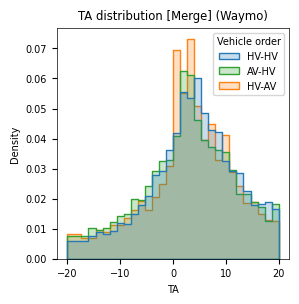

In [15]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
conflictType = "Merge"
histplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    x="TA", 
    bins=30,
    hue="Vehicle order",
    # col="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    common_norm=False,
    stat="density",
    palette=palette,
    multiple="layer",
    element="step",
    # aspect=1.0,
    # legend=False,
    # facet_kws=dict(sharey=False)
)

# plt.xlim([0, TTC_THRESHOLD])
# plt.ylim([0,0.15])
# plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TA distribution [{conflictType}] (Waymo)")
# plt.savefig(f"./outputs/plots/waymo_distribution_TA_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

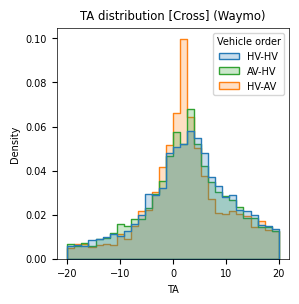

In [16]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3

plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
conflictType = "Cross"
histplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    x="TA", 
    bins=30,
    hue="Vehicle order",
    # col="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    common_norm=False,
    stat="density",
    palette=palette,
    multiple="layer",
    element="step",
    # aspect=1.0,
    # legend=False,
    # facet_kws=dict(sharey=False)
)

# plt.xlim([0, TTC_THRESHOLD])
# plt.ylim([0,0.15])
# plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TA distribution [{conflictType}] (Waymo)")
# plt.savefig(f"./outputs/plots/waymo_distribution_TA_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

## Distplots

### All

<Figure size 300x300 with 0 Axes>

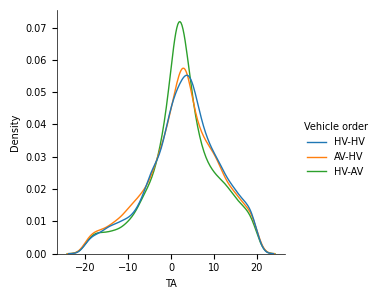

In [7]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

HVHV_COLOR = '#257ab6'
HVAV_COLOR = '#31a231'
AVHV_COLOR = '#ff8214'

conflictType = "Total"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    conflict_df, 
    x="TA", 
    # bins=50, 
    # col="Vehicle order",
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    height=3, 
    aspect=1,
    legend=True,
)

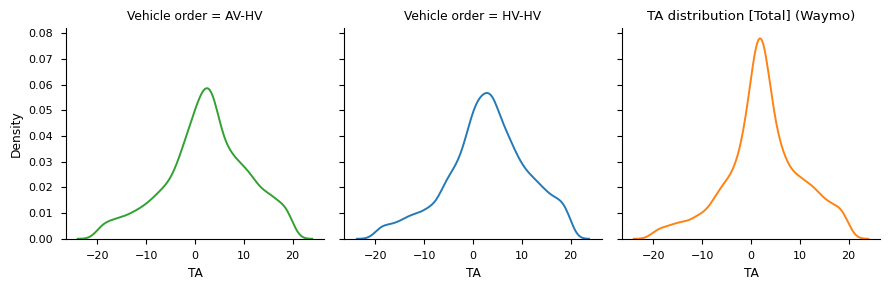

In [8]:
displot(
    data=conflict_df,
    x="TA", 
    hue="Vehicle order",
    col="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

# plt.xlim([0, TTC_THRESHOLD])
# plt.ylim([0,0.15])
# plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TA distribution [{conflictType}] (Waymo)")
plt.savefig(f"./outputs/plots/waymo_distribution_TA_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

## Histogram

### All

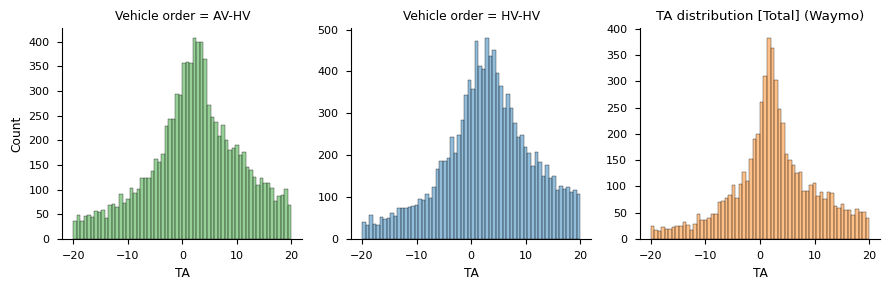

In [9]:
displot(
    data=conflict_df,
    x="TA", 
    hue="Vehicle order",
    col="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="hist",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
    facet_kws=dict(sharey=False)
)

# plt.xlim([0, TTC_THRESHOLD])
# plt.ylim([0,0.15])
# plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TA distribution [{conflictType}] (Waymo)")
plt.savefig(f"./outputs/plots/waymo_distribution_TA_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

## Violin

### All